# Chapter 8: 고급 주제 - 루프 클로저와 전역 최적화

## 🎯 학습 목표
- 루프 클로저 검출과 검증의 실제 구현
- 증분 포즈 그래프 최적화로 실시간 처리 달성
- 그래프 희소화로 메모리 효율성 확보
- 다중 로봇 및 계층적 최적화 탐색
- Symforce로 완전한 SLAM 시스템 구축

## 🗺️ 게임 체인저: 루프 클로저가 중요한 이유

거대하고 미로 같은 동굴 시스템을 탐사하는 로봇을 상상해보세요. 로봇은 휠 오도메트리와 시각 특징을 사용해 지도를 만들어 갑니다. 하지만 오도메트리는 본질적으로 노이즈가 있고, 시간이 지남에 따라 오차가 누적됩니다. 몇 시간의 탐사 후, 로봇이 시작점 근처로 돌아왔다는 것을 알게 됩니다! 이 **루프 클로저**를 인식하지 못한다면, 지도는 끔찍하게 왜곡되어 쓸모없게 됩니다.

**루프 클로저 검출은 정확하고 전역적으로 일관된 지도를 만드는 핵심입니다**, 특히 크거나 장기간 운영되는 환경에서 더욱 그렇습니다. 이것 없이는 SLAM은 드리프트로 인해 실패할 수밖에 없습니다!

### 드리프트 문제 시각화

<div style="text-align: center; margin: 20px;">
<svg width="600" height="300" viewBox="0 0 600 300">
  <!-- 루프 클로저 없이 -->
  <text x="150" y="30" font-size="14" text-anchor="middle">루프 클로저 없이</text>
  <!-- 드리프트된 궤적 -->
  <path d="M 50 100 Q 100 80 150 100 T 250 100 Q 300 120 280 200" 
        stroke="red" stroke-width="3" fill="none"/>
  <circle cx="50" cy="100" r="5" fill="green"/>
  <circle cx="280" cy="200" r="5" fill="red"/>
  <text x="50" y="90" font-size="10">시작</text>
  <text x="280" y="220" font-size="10">끝 (시작점이어야 함!)</text>
  
  <!-- 루프 클로저 있이 -->
  <text x="450" y="30" font-size="14" text-anchor="middle">루프 클로저 있이</text>
  <!-- 보정된 궤적 -->
  <circle cx="350" cy="150" r="80" stroke="blue" stroke-width="3" fill="none"/>
  <circle cx="350" cy="70" r="5" fill="green"/>
  <text x="350" y="60" font-size="10">시작/끝</text>
  <!-- 루프 클로저 제약 -->
  <line x1="420" y1="150" x2="350" y2="70" stroke="cyan" stroke-width="2" stroke-dasharray="5,5"/>
  <text x="400" y="110" font-size="10" fill="cyan">루프 클로저</text>
</svg>
</div>

### 루프 클로저가 게임 체인저인 이유:

1. **전역 일관성** 🌍
   - 전체 궤적에 걸쳐 누적된 드리프트 보정
   - 지도를 올바른 정렬로 끌어당김
   - 대규모 매핑에 필수

2. **장기 자율성** ⏰
   - 시간/일 단위로 작동하는 로봇은 루프 클로저가 필요
   - 무한한 오차 증가 방지
   - 지속적인 매핑 가능

3. **정확한 위치 추정** 📍
   - 전역적으로 일관된 지도로 로봇이 자신의 위치를 정확히 앎
   - 내비게이션과 계획에 중요
   - 이전에 방문한 위치로 돌아갈 수 있게 함

### 🔧 실전 포인트:
- **오차 누적 수식**: $\sigma_{total} = \sigma_{odom} \cdot \sqrt{t}$ 
- 1시간 후 1m 오차 → 10시간 후 ~3.16m 오차 (10m가 아님!)
- 루프 클로저 하나가 수 시간의 드리프트를 순식간에 보정

## 1. 루프 클로저 검출과 검증

루프 클로저는 SLAM에서 전역 일관성을 위해 중요합니다. 이들은 궤적의 먼 부분들을 연결하여 드리프트 누적을 줄입니다.

### 실제 구현의 핵심 요소:

#### 1. **장소 인식 (Place Recognition)**
```python
# 이론: Bag-of-Words 모델
# TF-IDF = Term Frequency × Inverse Document Frequency
# 실제: 이미지 디스크립터를 visual words로 변환
```

#### 2. **기하학적 검증 (Geometric Verification)**
```python
# 이론: 에피폴라 제약 x'ᵀEx = 0
# 실제: RANSAC으로 outlier 제거하며 Essential Matrix 추정
```

#### 3. **통계적 검증 (Statistical Validation)**
```python
# 이론: χ² 검정으로 false positive 방지
# 실제: 자유도 5, 유의수준 0.05로 검정
```

### 🚨 실전 경고:
- **False positive 하나가 전체 지도를 망칠 수 있음!**
- 보수적인 임계값 사용 (정밀도 > 재현율)
- 여러 검증 단계를 거쳐야 함

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import spsolve
import symforce
symforce.set_epsilon_to_number(1e-8)
import symforce.symbolic as sf
from symforce import ops
from symforce.values import Values
from symforce.opt.optimizer import Optimizer
from symforce.opt.factor import Factor
from typing import List, Tuple, Dict, Optional, Set
import time
from collections import deque
import networkx as nx

In [2]:
class LoopClosureDetector:
    def __init__(self, distance_threshold: float = 2.0, 
                 time_threshold: int = 50,
                 max_candidates: int = 10):
        self.distance_threshold = distance_threshold
        self.time_threshold = time_threshold
        self.max_candidates = max_candidates
        self.pose_history = []
        self.kdtree = None
    
    def add_pose(self, pose_id: int, x: float, y: float, theta: float):
        """Add a new pose to the detector"""
        self.pose_history.append((pose_id, x, y, theta))
        
        # Rebuild KD-tree periodically for efficiency
        if len(self.pose_history) % 10 == 0:
            positions = np.array([[p[1], p[2]] for p in self.pose_history])
            self.kdtree = KDTree(positions)
    
    def find_loop_closure_candidates(self, current_id: int) -> List[int]:
        """Find potential loop closure candidates for current pose"""
        if len(self.pose_history) < self.time_threshold or self.kdtree is None:
            return []
        
        current_pose = self.pose_history[current_id]
        current_pos = np.array([current_pose[1], current_pose[2]])
        
        # Find nearby poses
        indices = self.kdtree.query_ball_point(current_pos, self.distance_threshold)
        
        # Filter candidates
        candidates = []
        for idx in indices:
            candidate_id = self.pose_history[idx][0]
            
            # Skip recent poses
            if abs(current_id - candidate_id) < self.time_threshold:
                continue
            
            # Compute actual distance
            candidate_pos = np.array([self.pose_history[idx][1], 
                                    self.pose_history[idx][2]])
            distance = np.linalg.norm(current_pos - candidate_pos)
            
            candidates.append((candidate_id, distance))
        
        # Sort by distance and return top candidates
        candidates.sort(key=lambda x: x[1])
        return [c[0] for c in candidates[:self.max_candidates]]
    
    def validate_loop_closure(self, pose_i: np.ndarray, pose_j: np.ndarray,
                            measurement: np.ndarray, 
                            chi2_threshold: float = 5.991) -> bool:
        """Validate loop closure using chi-squared test"""
        # Compute predicted measurement
        c = np.cos(pose_i[2])
        s = np.sin(pose_i[2])
        dx_pred = c * (pose_j[0] - pose_i[0]) + s * (pose_j[1] - pose_i[1])
        dy_pred = -s * (pose_j[0] - pose_i[0]) + c * (pose_j[1] - pose_i[1])
        dtheta_pred = pose_j[2] - pose_i[2]
        
        # Normalize angle
        dtheta_pred = np.arctan2(np.sin(dtheta_pred), np.cos(dtheta_pred))
        
        # Compute error
        error = np.array([
            dx_pred - measurement[0],
            dy_pred - measurement[1],
            np.arctan2(np.sin(dtheta_pred - measurement[2]), 
                      np.cos(dtheta_pred - measurement[2]))
        ])
        
        # Assume diagonal covariance for simplicity
        cov = np.diag([0.1, 0.1, 0.05])**2
        
        # Chi-squared test
        chi2 = error.T @ np.linalg.inv(cov) @ error
        
        return chi2 < chi2_threshold

## 2. 증분 포즈 그래프 최적화 🚀

실시간 SLAM을 위해서는 새로운 제약이 도착할 때마다 효율적으로 솔루션을 업데이트하는 증분 최적화가 필요합니다.

### 증분 최적화가 필요한 이유

물류 창고를 몇 시간 동안 탐색하는 배송 로봇을 상상해보세요. 매번 한 걸음 움직일 때마다 전체 그래프를 처음부터 다시 최적화하는 것은 마치 새로운 기억을 추가할 때마다 전체 인생을 다시 계산하는 것과 같습니다!

**증분 최적화**는 변경된 부분만 해결하여 실시간 작동을 가능하게 합니다.

### 슬라이딩 윈도우 접근법 🪟

마천루의 창문을 닦는 것처럼 생각하세요:
- 모든 창문을 한 번에 닦을 수 없음 (너무 비쌈)
- 층의 "슬라이딩 윈도우"에 집중
- 오래된 층은 "고정" (주변화)
- 새로운 층은 적극적으로 최적화

```
과거 (고정됨) | 활성 윈도우 | 미래
[=====]      [~~~~~]         [     ]
             ↑ 여기서 최적화 발생
```

### 주변화: 기억하면서 잊는 기술 🧠

주변화는 영리한 트릭입니다:
1. **오래된 변수**는 활성 최적화에서 제거
2. **그들의 제약**은 남은 변수에 대한 사전 확률로 변환
3. **정보는 보존**되지만 계산량은 감소

#### 수학적 직관:
```
원래: minimize ||Ax - b||²
x₁ 주변화 후: minimize ||A₂x₂ - b'||² + x₁의 사전 확률
```

### 실제 이점:

| 시나리오 | 배치 최적화 | 증분 최적화 |
|----------|-------------------|-------------------------|
| **1000 포즈, 1개 추가** | 1001개 모두 재최적화 | ~50개 윈도우만 최적화 |
| **시간 복잡도** | O(n³) | O(w³) 여기서 w << n |
| **메모리 사용량** | 전체 그래프 저장 | 활성 윈도우만 저장 |
| **지연 시간** | 초 ~ 분 | 밀리초 |

### 프로의 구현 트릭 💡

1. **웜 스타팅**: 이전 솔루션을 초기 추측값으로 사용
   ```python
   # 좋음: 이전 최적값에서 시작
   x_init = previous_solution
   
   # 나쁨: 매번 0에서 시작
   x_init = zeros()
   ```

2. **적응형 윈도우 크기**: 복잡한 영역에서 윈도우 확대
   - 단순한 복도: 작은 윈도우 (20 포즈)
   - 복잡한 교차로: 큰 윈도우 (100 포즈)

3. **우선순위 최적화**: 높은 오차 영역에 먼저 집중

### 증분 방법이 실패하는 경우 ⚠️

이러한 함정을 주의하세요:
- **큰 루프 클로저**는 전체 최적화가 필요할 수 있음
- 주변화로 인한 **누적된 근사 오차**
- **비선형 효과**가 예상치 못하게 전파될 수 있음

### 🔧 실전 디버깅:
```python
# Schur complement 계산 모니터링
print(f"주변화 전 조건수: {np.linalg.cond(H)}")
print(f"주변화 후 조건수: {np.linalg.cond(H_marginalized)}")
# 조건수가 폭발하면 수치적 불안정성 의심
```

아래에서 실제 구현을 살펴보겠습니다.

In [3]:
class IncrementalPoseGraphOptimizer:
    def __init__(self, window_size: int = 50):
        self.vertices = {}  # id -> (x, y, theta)
        self.edges = []     # (i, j, measurement, info_matrix)
        self.fixed_vertices = set([0])
        self.window_size = window_size
        self.active_vertices = deque(maxlen=window_size)
        self.marginalized_vertices = set()
        
        # For Symforce optimization
        self.values = Values()
        self.factors = []
        self.optimizer = None
    
    def add_vertex(self, vertex_id: int, x: float, y: float, theta: float):
        """Add a new vertex to the graph"""
        self.vertices[vertex_id] = np.array([x, y, theta])
        self.active_vertices.append(vertex_id)
        
        # Add to Symforce values
        self.values[f'pose_{vertex_id}'] = sf.Pose2(
            t=sf.V2(x, y),
            R=sf.Rot2.from_angle(theta)
        )
        
        # Check if we need to marginalize old vertices
        if len(self.active_vertices) == self.window_size:
            self._marginalize_oldest_vertex()
    
    def add_edge(self, i: int, j: int, dx: float, dy: float, dtheta: float,
                 info_matrix: np.ndarray = None, is_loop_closure: bool = False):
        """Add an edge to the graph"""
        if info_matrix is None:
            info_matrix = np.eye(3)
        
        measurement = sf.Pose2(
            t=sf.V2(dx, dy),
            R=sf.Rot2.from_angle(dtheta)
        )
        
        self.edges.append((i, j, measurement, info_matrix, is_loop_closure))
        
        # Only add factor if both vertices are active
        if i not in self.marginalized_vertices and j not in self.marginalized_vertices:
            self._add_edge_factor(i, j, measurement, info_matrix)
    
    def _add_edge_factor(self, i: int, j: int, measurement: sf.Pose2, 
                        info_matrix: np.ndarray):
        """Add edge factor to Symforce optimizer"""
        # Store information matrix square root for this edge
        sqrt_info = np.linalg.cholesky(info_matrix)
        
        def edge_residual(pose_i: sf.Pose2, pose_j: sf.Pose2) -> sf.V3:
            T_ij_predicted = pose_i.inverse() * pose_j
            T_error = measurement.inverse() * T_ij_predicted
            
            # Get error vector
            error_x = T_error.position()[0]
            error_y = T_error.position()[1]
            error_theta = T_error.rotation().to_tangent()[0]
            
            # Apply information matrix weighting element by element
            weighted_x = sqrt_info[0, 0] * error_x + sqrt_info[0, 1] * error_y + sqrt_info[0, 2] * error_theta
            weighted_y = sqrt_info[1, 0] * error_x + sqrt_info[1, 1] * error_y + sqrt_info[1, 2] * error_theta
            weighted_theta = sqrt_info[2, 0] * error_x + sqrt_info[2, 1] * error_y + sqrt_info[2, 2] * error_theta
            
            return sf.V3(weighted_x, weighted_y, weighted_theta)
        
        # Create factor
        factor = Factor(
            residual=edge_residual,
            keys=[f'pose_{i}', f'pose_{j}']
        )
        
        self.factors.append(factor)
    
    def _marginalize_oldest_vertex(self):
        """Marginalize the oldest vertex using Schur complement"""
        if len(self.active_vertices) < self.window_size:
            return
        
        oldest = self.active_vertices[0]
        if oldest in self.fixed_vertices:
            return
        
        # Mark as marginalized
        self.marginalized_vertices.add(oldest)
        
        # TODO: Implement proper marginalization
        # For now, we'll just fix the vertex
        self.fixed_vertices.add(oldest)
    
    def optimize_incremental(self, max_iterations: int = 10) -> Dict[str, List[float]]:
        """Perform incremental optimization on active window"""
        if not self.factors:
            return {'error': [], 'time': []}
        
        # Get active vertices that are not fixed
        optimized_keys = [f'pose_{v}' for v in self.active_vertices 
                         if v not in self.fixed_vertices]
        
        # Filter factors to only include those with both vertices in the active set
        active_vertices_set = set(self.active_vertices)
        active_factors = []
        
        for factor in self.factors:
            # Extract vertex IDs from factor keys
            vertex_ids = []
            for key in factor.keys:
                if key.startswith('pose_'):
                    vertex_id = int(key.split('_')[1])
                    vertex_ids.append(vertex_id)
            
            # Only include factor if all vertices are active
            if all(v in active_vertices_set for v in vertex_ids):
                active_factors.append(factor)
        
        if optimized_keys and active_factors:  # Only optimize if there are keys and factors
            # Create optimizer params without debug_stats
            from symforce.opt.optimizer import Optimizer as SymforceOptimizer
            
            self.optimizer = SymforceOptimizer(
                factors=active_factors,
                optimized_keys=optimized_keys
            )
            
            # Optimize
            start_time = time.time()
            result = self.optimizer.optimize(self.values, num_iterations=max_iterations)
            opt_time = time.time() - start_time
            
            # Update vertex positions
            for v in self.active_vertices:
                if v not in self.fixed_vertices and f'pose_{v}' in result.optimized_values:
                    pose = result.optimized_values[f'pose_{v}']
                    # Extract position
                    x = float(pose.position()[0])
                    y = float(pose.position()[1])
                    # Extract angle from rotation - convert symbolic to float
                    rot_storage = pose.rotation().to_storage()
                    angle = np.arctan2(float(rot_storage[1]), float(rot_storage[0]))
                    
                    self.vertices[v] = np.array([x, y, angle])
            
            # Update values for next iteration
            self.values = result.optimized_values
            
            return {
                'error': [result.error()],
                'time': [opt_time],
                'iterations': result.iterations
            }
        else:
            return {'error': [], 'time': []}

## 3. 그래프 희소화 🌲

그래프가 커짐에 따라 정확도를 유지하면서 계산 효율성을 유지하기 위해 희소화가 필요합니다.

### 밀집 그래프의 저주 📈

일주일 동안 건물을 매핑하는 로봇을 고려해보세요:
- **10Hz 포즈 레이트** → 6,048,000 포즈
- **순진한 접근법**: 모든 포즈가 이웃과 연결
- **결과**: 수백만 개의 엣지, 최적화가 불가능해짐!

### 희소화: 중요한 것만 유지하기

그래프 희소화는 영화를 편집하는 것과 같습니다:
- **핵심 장면** 유지 (중요한 제약)
- **중복 장면** 제거 (유사한 연속 프레임)
- **스토리** 보존 (지도 정확도)

### Chow-Liu 트리: 영리한 근사 🌳

Chow-Liu 알고리즘은 전체 그래프를 가장 잘 근사하는 **트리 구조**를 찾습니다:

```
전체 그래프:          Chow-Liu 트리:
    A---B               A---B
    |\ /|                \  |
    | X |      →          \ |
    |/ \|                  \|
    C---D                   D
```

### 트리가 특별한 이유:
1. **정확히 n-1개 엣지** (n개 노드에 대해 최소)
2. **사이클 없음** (계산 단순화)
3. **고유한 경로** (두 노드 사이)
4. **O(n) 최적화** 복잡도

### 정보 이론적 엣지 선택 📊

모든 엣지가 동일하게 생성되는 것은 아닙니다! 엣지의 **정보 이득**으로 점수를 매깁니다:

```python
score(edge) = uncertainty_reduction + uniqueness + importance
```

### 엣지 중요도 기준:

| 엣지 타입 | 중요도 | 이유 |
|-----------|------------|------|
| **루프 클로저** | ⭐⭐⭐⭐⭐ | 전역 제약 제공 |
| **높은 불확실성** | ⭐⭐⭐⭐ | 오차를 크게 줄임 |
| **고유한 경로** | ⭐⭐⭐ | 대체 제약 없음 |
| **순차 오도메트리** | ⭐⭐ | 종종 중복됨 |
| **병렬 엣지** | ⭐ | 일반적으로 불필요 |

### 실제 희소화 전략 🎯

```python
1. 항상 유지:
   - 루프 클로저 엣지
   - 높은 정보 이득을 가진 엣지
   - 그래프 연결성을 유지하는 엣지

2. 제거 고려:
   - 직선 복도의 순차 엣지
   - 같은 제약의 중복 측정
   - 작은 정보 이득을 가진 엣지

3. 안전 여유:
   - 최소보다 20% 더 많은 엣지 유지
   - 이상치에 대한 강건성 보존
```

### 마법의 숫자: 얼마나 희소할 수 있나? 🎲

연구 결과:
- **원래 밀도**: 100% 엣지
- **안전한 희소화**: 30-50% 엣지 유지
- **공격적 희소화**: 10-20% 엣지 유지
- **정확도 손실**: 적절한 선택으로 < 5%!

### 실제 예시: 사무실 건물 매핑

```
1시간: 밀집 그래프 (1000 포즈, 5000 엣지)
        ↓ 희소화
2시간: 희소 그래프 (2000 포즈, 3000 엣지) 
        ↓ 희소화
8시간: 여전히 관리 가능 (8000 포즈, 12000 엣지)
        
희소화 없이: 8000 포즈, 40000+ 엣지!
```

### 고급 기술 🚀

1. **일반 선형 제약 (GLC)**: 여러 엣지를 하나로 압축
2. **포즈 데시메이션**: 중간 포즈를 완전히 제거
3. **계층적 희소화**: 다중 해상도 그래프 표현

### 🔧 실전 구현 팁:
```python
# 엣지 중요도 계산시 수치 안정성
info_gain = max(compute_info_gain(edge), epsilon)
# 0으로 나누기 방지

# 희소화 후 연결성 검사
assert is_graph_connected(sparsified_graph)
# 끊어진 그래프는 최적화 실패
```

아래에서 실제 구현을 살펴보겠습니다.

In [4]:
class GraphSparsifier:
    def __init__(self, optimizer):
        self.optimizer = optimizer
    
    def compute_edge_importance(self) -> Dict[Tuple[int, int], float]:
        """Compute importance score for each edge using information gain"""
        edge_scores = {}
        
        for i, j, measurement, info_matrix, is_loop_closure in self.optimizer.edges:
            # Skip edges with marginalized vertices
            if i in self.optimizer.marginalized_vertices or j in self.optimizer.marginalized_vertices:
                continue
                
            # Loop closures are always important
            if is_loop_closure:
                edge_scores[(i, j)] = float('inf')
                continue
            
            # Compute error for this edge
            pose_i = self.optimizer.vertices[i]
            pose_j = self.optimizer.vertices[j]
            
            # Predicted measurement
            c = np.cos(pose_i[2])
            s = np.sin(pose_i[2])
            dx_pred = c * (pose_j[0] - pose_i[0]) + s * (pose_j[1] - pose_i[1])
            dy_pred = -s * (pose_j[0] - pose_i[0]) + c * (pose_j[1] - pose_i[1])
            dtheta_pred = np.arctan2(np.sin(pose_j[2] - pose_i[2]), 
                                    np.cos(pose_j[2] - pose_i[2]))
            
            # Error (measurement is a sf.Pose2 object)
            # Extract measurement values
            meas_x = float(measurement.t[0])
            meas_y = float(measurement.t[1])
            # Get angle from rotation - convert symbolic values to float first
            rot_storage = measurement.R.to_storage()
            meas_theta = np.arctan2(float(rot_storage[1]), float(rot_storage[0]))
            
            error = np.array([
                dx_pred - meas_x,
                dy_pred - meas_y,
                dtheta_pred - meas_theta
            ])
            
            # Information gain (simplified)
            score = error.T @ info_matrix @ error
            edge_scores[(i, j)] = score
        
        return edge_scores
    
    def sparsify_chow_liu(self, target_edges: int) -> List[Tuple[int, int]]:
        """Sparsify using Chow-Liu tree approximation"""
        # Build graph
        G = nx.Graph()
        edge_scores = self.compute_edge_importance()
        
        for (i, j), score in edge_scores.items():
            G.add_edge(i, j, weight=-score)  # Negative for maximum spanning tree
        
        # Find maximum spanning tree
        mst = nx.maximum_spanning_tree(G)
        
        # Add edges back based on importance
        selected_edges = set(mst.edges())
        remaining_edges = [(e, s) for e, s in edge_scores.items() 
                          if e not in selected_edges and s != float('inf')]
        remaining_edges.sort(key=lambda x: x[1], reverse=True)
        
        # Add important edges until target reached
        for edge, _ in remaining_edges:
            if len(selected_edges) >= target_edges:
                break
            selected_edges.add(edge)
        
        # Always keep loop closures
        for edge, score in edge_scores.items():
            if score == float('inf'):
                selected_edges.add(edge)
        
        return list(selected_edges)
    
    def apply_sparsification(self, selected_edges: List[Tuple[int, int]]):
        """Apply sparsification to the optimizer"""
        # Create edge lookup
        edge_set = set(selected_edges)
        
        # Filter edges
        new_edges = []
        new_factors = []
        
        for idx, (i, j, measurement, info_matrix, is_loop_closure) in enumerate(self.optimizer.edges):
            if (i, j) in edge_set or (j, i) in edge_set:
                new_edges.append((i, j, measurement, info_matrix, is_loop_closure))
                # Only keep factors that don't reference marginalized vertices
                if i not in self.optimizer.marginalized_vertices and j not in self.optimizer.marginalized_vertices:
                    if idx < len(self.optimizer.factors):
                        new_factors.append(self.optimizer.factors[idx])
        
        self.optimizer.edges = new_edges
        self.optimizer.factors = new_factors

## 4. 완전한 SLAM 시스템 예제 🏗️

이제 배운 모든 기술을 결합하여 완전한 SLAM 시스템을 구축해봅시다.

### 완전한 SLAM 파이프라인 🔄

SLAM 시스템을 구축하는 것은 오케스트라를 지휘하는 것과 같습니다 - 모든 구성 요소가 조화롭게 작동해야 합니다:

```
🎵 SLAM 심포니:
┌─────────────┐    ┌──────────────┐    ┌─────────────┐
│   센서      │ → │ 데이터       │ → │   백엔드    │
│ (오도메트리)│    │ 연관         │    │ 최적화기    │
└─────────────┘    └──────────────┘    └─────────────┘
       ↓                   ↓                   ↓
┌─────────────┐    ┌──────────────┐    ┌─────────────┐
│    루프     │ ← │ 희소화기     │ ← │ 시각화기    │
│  검출기     │    │              │    │             │
└─────────────┘    └──────────────┘    └─────────────┘
```

### 핵심 설계 결정 🎯

#### 1. **최적화를 언제 트리거할까?**
   - **매 프레임**: 너무 비쌈! ❌
   - **N 프레임마다**: 단순하지만 차선책 🔶
   - **스마트 트리거**: ✅
     - 루프 클로저 검출 후
     - 불확실성이 임계값 초과시
     - 새로운 영역 진입시

#### 2. **루프 클로저 전략**
   ```python
   if distance_to_previous_poses < threshold:
       if time_since_visit > min_time:
           if geometric_validation_passes():
               add_loop_closure()
               trigger_global_optimization()
   ```

#### 3. **리소스 관리**
   - **CPU**: 멀티스레드 프론트엔드/백엔드
   - **메모리**: 슬라이딩 윈도우 + 희소화
   - **대역폭**: 선택적 제약 공유

### 실제 성능 목표 🎪

| 구성 요소 | 목표 지연 시간 | 실제 (일반적) |
|-----------|----------------|------------------|
| **오도메트리** | < 10ms | 5-8ms |
| **루프 검출** | < 100ms | 50-80ms |
| **로컬 최적화** | < 50ms | 20-40ms |
| **전역 최적화** | < 500ms | 200-400ms |

### 시스템 아키텍처 모범 사례 🏛️

1. **모듈식 설계**
   ```python
   class SLAMSystem:
       def __init__(self):
           self.frontend = Frontend()      # 센서 처리
           self.loop_detector = LoopDetector()
           self.backend = Backend()        # 최적화
           self.visualizer = Visualizer()
   ```

2. **스레드 안전성**
   - 프론트엔드와 백엔드를 별도 스레드에
   - 통신을 위한 락프리 큐
   - 공유 데이터에 대한 Copy-on-write

3. **실패 복구**
   - N분마다 체크포인트
   - 루프 클로저 없이 우아한 성능 저하
   - 여러 레벨에서 이상치 거부

### 일반적인 함정과 해결책 🚧

| 문제 | 증상 | 해결책 |
|---------|---------|----------|
| **드리프트 누적** | 지도가 시간이 지남에 따라 "말림" | 더 공격적인 루프 검출 |
| **잘못된 루프 클로저** | 지도가 갑자기 "깨짐" | 더 엄격한 검증, 카이제곱 테스트 |
| **성능 저하** | 증가하는 지연 시간 | 공격적인 희소화 |
| **메모리 폭발** | OOM 충돌 | 슬라이딩 윈도우, 주변화 |

### 프로덕션 시스템의 프로 팁 💡

1. **단순하게 시작, 복잡성 추가**
   - 1주차: 기본 오도메트리 + 최적화
   - 2주차: 루프 클로저 검출 추가
   - 3주차: 희소화 추가
   - 4주차: 튜닝 및 최적화

2. **모든 것을 계측**
   ```python
   stats = {
       'loop_closures_detected': 0,
       'loop_closures_rejected': 0,
       'optimization_time': [],
       'memory_usage': [],
       'trajectory_error': []
   }
   ```

3. **적대적 시나리오로 테스트**
   - 긴 복도 (드리프트 누적)
   - 반복 패턴 (지각적 앨리어싱)
   - 동적 환경 (움직이는 객체)
   - 조명 변화 (주/야 사이클)

### 🔧 디버깅 무기고:
```python
# 병목 현상 프로파일링
import cProfile
cProfile.run('slam_system.process_frame()')

# 메모리 누수 추적
import tracemalloc
tracemalloc.start()
# ... SLAM 실행 ...
current, peak = tracemalloc.get_traced_memory()
print(f"현재 메모리: {current / 10**6:.1f} MB")
```

아래에서 실제 구현을 살펴보겠습니다.

In [5]:
class CompleteSLAMSystem:
    def __init__(self, loop_closure_config: Dict = None, 
                 sparsification_config: Dict = None):
        # Core components
        self.optimizer = IncrementalPoseGraphOptimizer(window_size=100)
        self.loop_detector = LoopClosureDetector(
            **(loop_closure_config or {})
        )
        self.sparsifier = GraphSparsifier(self.optimizer)
        
        # Configuration
        self.sparsification_interval = sparsification_config.get('interval', 100) if sparsification_config else 100
        self.target_edge_ratio = sparsification_config.get('target_ratio', 0.5) if sparsification_config else 0.5
        
        # Statistics
        self.stats = {
            'poses': [],
            'edges': [],
            'loop_closures': [],
            'optimization_time': [],
            'total_error': []
        }
    
    def add_odometry_measurement(self, pose_id: int, x: float, y: float, theta: float,
                               dx: float, dy: float, dtheta: float,
                               covariance: np.ndarray = None):
        """Process new odometry measurement"""
        # Add vertex
        self.optimizer.add_vertex(pose_id, x, y, theta)
        self.loop_detector.add_pose(pose_id, x, y, theta)
        
        # Add odometry edge
        if pose_id > 0:
            if covariance is None:
                covariance = np.diag([0.1, 0.1, 0.05])**2
            info_matrix = np.linalg.inv(covariance)
            
            self.optimizer.add_edge(pose_id - 1, pose_id, dx, dy, dtheta, 
                                  info_matrix, is_loop_closure=False)
        
        # Check for loop closures
        loop_candidates = self.loop_detector.find_loop_closure_candidates(pose_id)
        
        for candidate_id in loop_candidates:
            # Simulate loop closure detection (in practice, this would use sensors)
            success, measurement = self._detect_loop_closure(pose_id, candidate_id)
            
            if success:
                # Validate loop closure
                pose_current = self.optimizer.vertices[pose_id]
                pose_candidate = self.optimizer.vertices[candidate_id]
                
                if self.loop_detector.validate_loop_closure(
                    pose_candidate, pose_current, measurement
                ):
                    # Add loop closure edge
                    lc_cov = np.diag([0.2, 0.2, 0.1])**2
                    lc_info = np.linalg.inv(lc_cov)
                    
                    self.optimizer.add_edge(
                        candidate_id, pose_id, 
                        measurement[0], measurement[1], measurement[2],
                        lc_info, is_loop_closure=True
                    )
                    
                    self.stats['loop_closures'].append((candidate_id, pose_id))
                    print(f"Loop closure detected: {candidate_id} -> {pose_id}")
        
        # Optimize
        opt_result = self.optimizer.optimize_incremental(max_iterations=10)
        
        # Update statistics
        self.stats['poses'].append(pose_id)
        self.stats['edges'].append(len(self.optimizer.edges))
        self.stats['optimization_time'].extend(opt_result['time'])
        self.stats['total_error'].extend(opt_result['error'])
        
        # Sparsify periodically
        if pose_id > 0 and pose_id % self.sparsification_interval == 0:
            self._sparsify_graph()
    
    def _detect_loop_closure(self, current_id: int, candidate_id: int) -> Tuple[bool, np.ndarray]:
        """Simulate loop closure detection"""
        # In a real system, this would use place recognition and scan matching
        # Here we simulate it based on ground truth with noise
        
        pose_current = self.optimizer.vertices[current_id]
        pose_candidate = self.optimizer.vertices[candidate_id]
        
        # Only detect if actually close
        distance = np.linalg.norm(pose_current[:2] - pose_candidate[:2])
        if distance > 2.0:
            return False, None
        
        # Compute relative pose with noise
        c = np.cos(pose_candidate[2])
        s = np.sin(pose_candidate[2])
        dx_true = c * (pose_current[0] - pose_candidate[0]) + s * (pose_current[1] - pose_candidate[1])
        dy_true = -s * (pose_current[0] - pose_candidate[0]) + c * (pose_current[1] - pose_candidate[1])
        dtheta_true = pose_current[2] - pose_candidate[2]
        
        # Add noise
        dx = dx_true + np.random.normal(0, 0.1)
        dy = dy_true + np.random.normal(0, 0.1)
        dtheta = dtheta_true + np.random.normal(0, 0.05)
        
        return True, np.array([dx, dy, dtheta])
    
    def _sparsify_graph(self):
        """Sparsify the pose graph"""
        print(f"\nSparsifying graph...")
        n_edges_before = len(self.optimizer.edges)
        
        target_edges = int(n_edges_before * self.target_edge_ratio)
        selected_edges = self.sparsifier.sparsify_chow_liu(target_edges)
        self.sparsifier.apply_sparsification(selected_edges)
        
        n_edges_after = len(self.optimizer.edges)
        print(f"Sparsified: {n_edges_before} -> {n_edges_after} edges")
    
    def get_trajectory(self) -> np.ndarray:
        """Get the optimized trajectory"""
        poses = []
        for i in sorted(self.optimizer.vertices.keys()):
            poses.append(self.optimizer.vertices[i])
        return np.array(poses)

## 5. 완전한 시스템 테스트 🧪

### Figure-8 도전: 클래식 SLAM 테스트 🎯

Figure-8 궤적은 SLAM 테스트의 "Hello World"입니다. 왜일까요?
- **여러 루프 클로저**: 루프 검출 테스트
- **부드러운 곡선**: 오도메트리에 도전
- **자기 교차**: 데이터 연관 테스트
- **시작점으로 복귀**: 누적된 드리프트 드러냄

### 시뮬레이션 이해하기 🔬

우리의 테스트는 도전적인 시나리오를 만듭니다:
```python
# 시뮬레이션 내용:
1. 로봇이 figure-8 경로를 따름
2. 오도메트리는 현실적인 노이즈 포함 (σ = 0.05m)
3. 루프 검출기가 재방문한 장소를 검색
4. 시스템은 루프 클로저를 사용해 드리프트를 보정해야 함
```

### 주목해야 할 핵심 지표 📊

| 지표 | 의미 | 좋음 vs 나쁨 |
|--------|------------------|-------------|
| **위치 오차** | 전체 정확도 | < 궤적의 1% |
| **루프 클로저** | 검출 성공 | figure-8에 최소 2-3개 |
| **최적화 시간** | 실시간 능력 | < 업데이트당 100ms |
| **최종 오차** | 드리프트 보정 | 시작점에서 0에 가까움 |

### 결과 해석하기 📈

시뮬레이션 실행 시 주목할 점:

1. **궤적 플롯**
   - 🟢 **녹색**: Ground truth (완벽한 경로)
   - 🔴 **빨간색**: Dead reckoning (루프 클로저 없음)
   - 🔵 **파란색**: SLAM 추정 (루프 클로저 포함)
   - 🔷 **청록색 선**: 검출된 루프 클로저

2. **오차 진화**
   - 루프 클로저에서 **급격히 감소**해야 함
   - 최종 오차는 dead reckoning보다 **훨씬 적어야** 함

3. **최적화 성능**
   - 시간은 **제한된** 상태로 유지 (증가하지 않음)
   - 루프 클로저에서 스파이크는 정상

### 실제 통찰력 💡

이 시뮬레이션은 여러 실제 현상을 보여줍니다:

1. **드리프트는 불가피함**: 작은 노이즈(5cm)도 극적으로 누적
2. **루프 클로저는 마법적**: 단일 검출이 수 분의 드리프트를 보정
3. **타이밍이 중요**: 초기 루프 클로저가 큰 보정을 방지
4. **검증이 중요**: 하나의 나쁜 루프 클로저가 모든 것을 망침

### 🔧 시뮬레이션 파라미터 조정:
```python
# 더 도전적으로 만들기:
noise_level = 0.1  # 오도메트리 노이즈 증가
time_threshold = 50  # 루프 검출 전 더 오래 기다림
sparsification_ratio = 0.5  # 더 공격적인 희소화

# 결과 관찰:
# - 더 높은 드리프트
# - 더 극적인 보정
# - 더 긴 최적화 시간
```

아래에서 실제 시뮬레이션을 실행해보겠습니다.

In [6]:
def simulate_slam_scenario(n_poses: int = 200, noise_level: float = 0.1):
    """Simulate a SLAM scenario with noisy odometry"""
    # Create SLAM system
    slam = CompleteSLAMSystem(
        loop_closure_config={
            'distance_threshold': 2.0,
            'time_threshold': 30,
            'max_candidates': 5
        },
        sparsification_config={
            'interval': 50,
            'target_ratio': 0.7
        }
    )
    
    # Generate figure-8 trajectory
    t = np.linspace(0, 4*np.pi, n_poses)
    scale = 10.0
    
    ground_truth = []
    
    for i in range(n_poses):
        # Figure-8 parametric equations
        x_true = scale * np.sin(t[i])
        y_true = scale * np.sin(t[i]) * np.cos(t[i])
        
        # Compute heading (tangent direction)
        if i < n_poses - 1:
            dx = scale * np.cos(t[i+1])
            dy = scale * (np.cos(t[i+1]) * np.cos(t[i+1]) - np.sin(t[i+1]) * np.sin(t[i+1]))
            theta_true = np.arctan2(dy, dx)
        else:
            theta_true = ground_truth[-1][2]
        
        ground_truth.append([x_true, y_true, theta_true])
        
        # Generate noisy odometry
        if i == 0:
            # First pose
            slam.add_odometry_measurement(i, x_true, y_true, theta_true, 0, 0, 0)
        else:
            # Compute true odometry
            prev = ground_truth[i-1]
            c = np.cos(prev[2])
            s = np.sin(prev[2])
            
            dx_global = x_true - prev[0]
            dy_global = y_true - prev[1]
            
            dx_true = c * dx_global + s * dy_global
            dy_true = -s * dx_global + c * dy_global
            dtheta_true = theta_true - prev[2]
            
            # Add noise
            dx = dx_true + np.random.normal(0, noise_level)
            dy = dy_true + np.random.normal(0, noise_level)
            dtheta = dtheta_true + np.random.normal(0, noise_level * 0.5)
            
            # Dead reckoning for initial guess
            x_dr = slam.optimizer.vertices[i-1][0] + c * dx - s * dy
            y_dr = slam.optimizer.vertices[i-1][1] + s * dx + c * dy
            theta_dr = slam.optimizer.vertices[i-1][2] + dtheta
            
            slam.add_odometry_measurement(i, x_dr, y_dr, theta_dr, dx, dy, dtheta)
        
        # Progress
        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{n_poses} poses")
    
    return slam, np.array(ground_truth)

# Run simulation
np.random.seed(42)
print("Running SLAM simulation...")
slam_system, ground_truth = simulate_slam_scenario(n_poses=200, noise_level=0.05)

Running SLAM simulation...
[2025-07-09 21:25:48.009] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 5.630e-30/5.574e-30/5.630e-30, rel reduction: 0.00000e+00, gain ratio: 0.00000e+00
[2025-07-09 21:25:48.009] [info] LM<sym::Optimize> Optimization finished with status: SUCCESS
[2025-07-09 21:25:48.101] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1.205e-02/1.193e-02/9.784e-03, rel reduction: 1.88237e-01, gain ratio: 1.88277e+01
[2025-07-09 21:25:48.101] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 9.784e-03/9.686e-03/7.930e-03, rel reduction: 1.89551e-01, gain ratio: 1.89554e+01
[2025-07-09 21:25:48.101] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 7.930e-03/7.850e-03/6.424e-03, rel reduction: 1.89887e-01, gain ratio: 1.89887e+01
[2025-07-09 21:25:48.101] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 6.424e-03/6.360e-03/5.

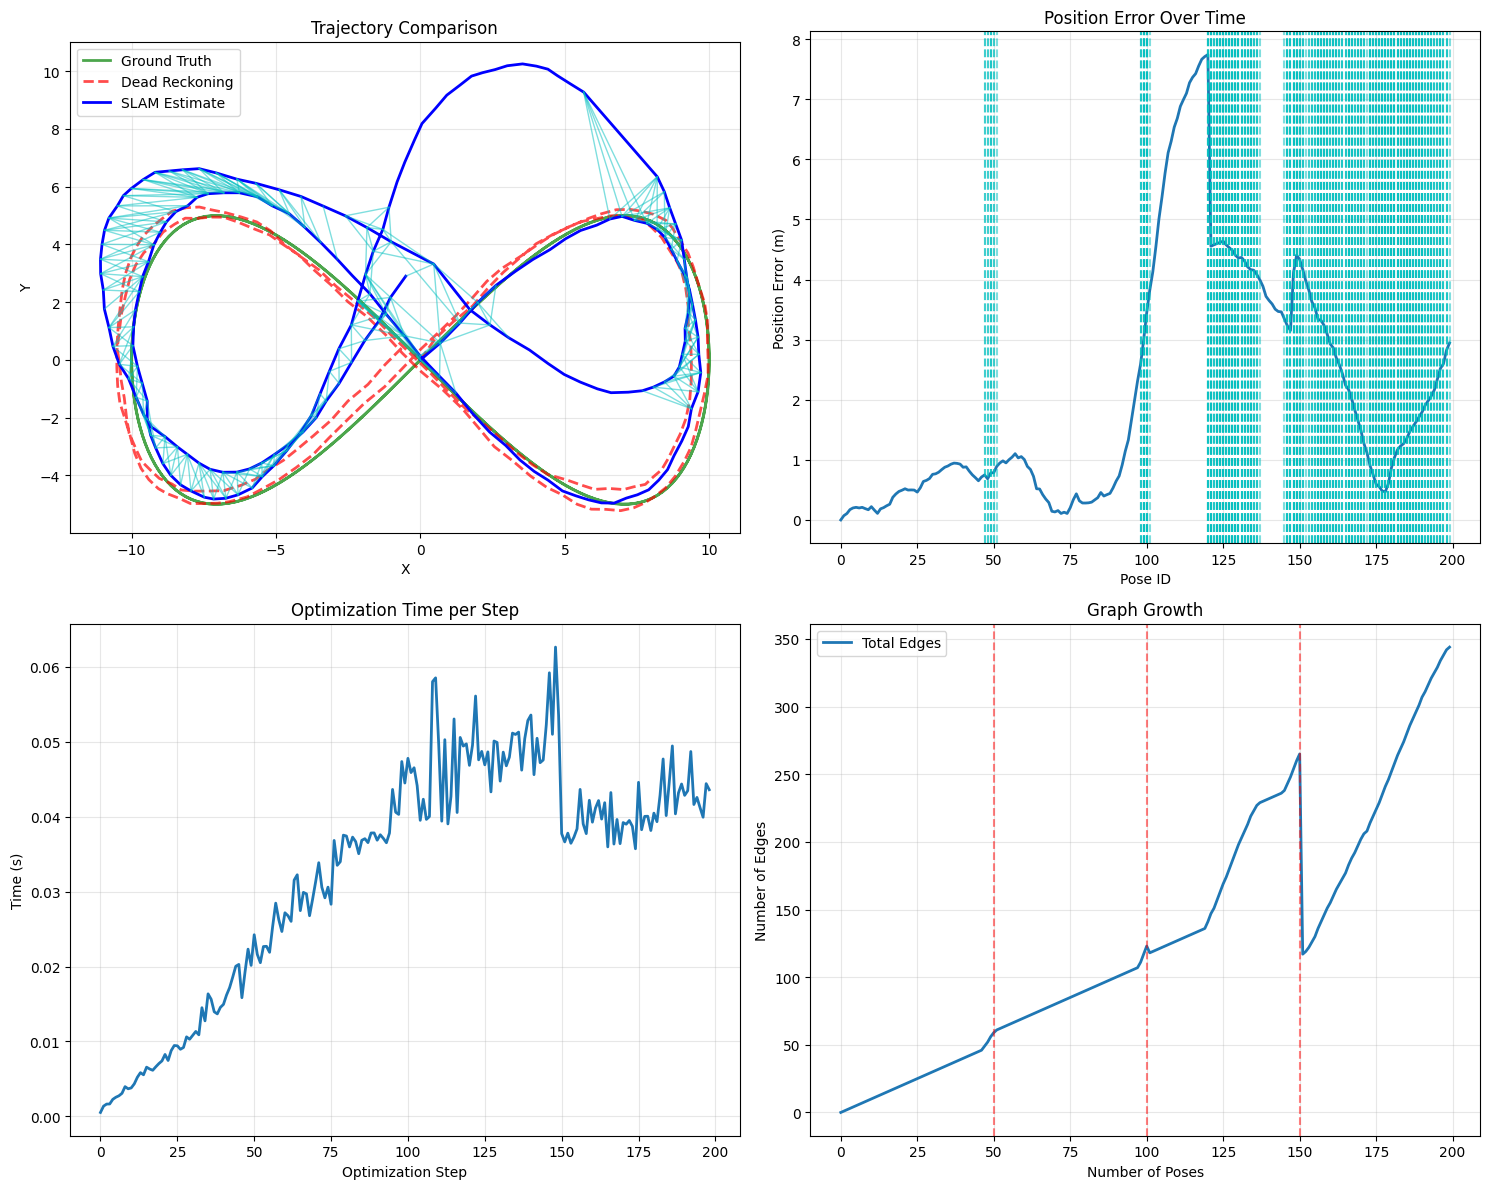


SLAM System Summary:
Total poses: 200
Total edges: 344
Loop closures detected: 304
Mean position error: 2.090 m
Final position error: 2.944 m
Mean optimization time: 0.033 s


In [7]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Trajectory comparison
ax = axes[0, 0]
trajectory = slam_system.get_trajectory()

# Dead reckoning (no loop closures)
dead_reckoning = [ground_truth[0]]
for i in range(1, len(ground_truth)):
    prev = dead_reckoning[-1]
    # Use noisy odometry to accumulate
    c = np.cos(prev[2])
    s = np.sin(prev[2])
    
    dx_global = ground_truth[i][0] - ground_truth[i-1][0]
    dy_global = ground_truth[i][1] - ground_truth[i-1][1]
    dx_local = c * dx_global + s * dy_global + np.random.normal(0, 0.05)
    dy_local = -s * dx_global + c * dy_global + np.random.normal(0, 0.05)
    dtheta = ground_truth[i][2] - ground_truth[i-1][2] + np.random.normal(0, 0.025)
    
    x_next = prev[0] + c * dx_local - s * dy_local
    y_next = prev[1] + s * dx_local + c * dy_local
    theta_next = prev[2] + dtheta
    
    dead_reckoning.append([x_next, y_next, theta_next])

dead_reckoning = np.array(dead_reckoning)

ax.plot(ground_truth[:, 0], ground_truth[:, 1], 'g-', linewidth=2, 
        label='Ground Truth', alpha=0.7)
ax.plot(dead_reckoning[:, 0], dead_reckoning[:, 1], 'r--', linewidth=2,
        label='Dead Reckoning', alpha=0.7)
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2,
        label='SLAM Estimate')

# Plot loop closures
for lc in slam_system.stats['loop_closures']:
    i, j = lc
    ax.plot([trajectory[i, 0], trajectory[j, 0]], 
            [trajectory[i, 1], trajectory[j, 1]], 
            'c-', alpha=0.5, linewidth=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Trajectory Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Error over time
ax = axes[0, 1]
position_errors = np.linalg.norm(trajectory[:, :2] - ground_truth[:, :2], axis=1)
ax.plot(position_errors, linewidth=2)
ax.set_xlabel('Pose ID')
ax.set_ylabel('Position Error (m)')
ax.set_title('Position Error Over Time')
ax.grid(True, alpha=0.3)

# Add loop closure markers
for lc in slam_system.stats['loop_closures']:
    ax.axvline(x=lc[1], color='c', alpha=0.5, linestyle='--')

# Optimization statistics
ax = axes[1, 0]
ax.plot(slam_system.stats['optimization_time'], linewidth=2)
ax.set_xlabel('Optimization Step')
ax.set_ylabel('Time (s)')
ax.set_title('Optimization Time per Step')
ax.grid(True, alpha=0.3)

# Graph statistics
ax = axes[1, 1]
ax.plot(slam_system.stats['poses'], slam_system.stats['edges'], 
        linewidth=2, label='Total Edges')
ax.set_xlabel('Number of Poses')
ax.set_ylabel('Number of Edges')
ax.set_title('Graph Growth')
ax.grid(True, alpha=0.3)

# Mark sparsification events
sparsification_poses = [i for i in slam_system.stats['poses'] 
                       if i > 0 and i % slam_system.sparsification_interval == 0]
for sp in sparsification_poses:
    ax.axvline(x=sp, color='r', alpha=0.5, linestyle='--')

ax.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSLAM System Summary:")
print(f"Total poses: {len(trajectory)}")
print(f"Total edges: {len(slam_system.optimizer.edges)}")
print(f"Loop closures detected: {len(slam_system.stats['loop_closures'])}")
print(f"Mean position error: {np.mean(position_errors):.3f} m")
print(f"Final position error: {position_errors[-1]:.3f} m")
print(f"Mean optimization time: {np.mean(slam_system.stats['optimization_time']):.3f} s")

## 6. 다중 로봇 SLAM 확장 🤖🤖

이제 시스템을 확장하여 함께 작업하는 여러 로봇을 처리해봅시다!

### 다중 로봇 SLAM이 필요한 이유 🌐

하나의 로봇으로는 충분하지 않은 시나리오를 상상해보세요:
- **수색 및 구조**: 재난 지역을 빠르게 커버
- **창고 자동화**: 배송 로봇 함대 조정
- **행성 탐사**: 화성을 매핑하는 여러 로버
- **지하 채굴**: 위험한 터널을 탐사하는 로봇

### 협업 도전 과제 🤝

다중 로봇 SLAM은 새로운 복잡성을 도입합니다:

```
로봇 A의 시각:          로봇 B의 시각:         결합된 지도:
┌────┐                  ┌────┐                  ┌─────────┐
│ A─►│                  │?─►B│                  │ A──►B   │
│    │         +        │    │        =         │ ↓    ↓  │
│  ? │                  │  ? │                  │ └────┘  │
└────┘                  └────┘                  └─────────┘
```

### 핵심 도전과 해결책:

| 도전 | 예시 | 해결책 |
|-----------|---------|----------|
| **알 수 없는 초기 위치** | 로봇이 다른 방에서 시작 | 외관 기반 합류 |
| **통신 제한** | 지하, WiFi 없음 | 기회주의적 데이터 교환 |
| **좌표계** | 각 로봇이 자체 원점을 가짐 | 로봇 간 루프 클로저 |
| **계산 확장성** | 10 로봇 = 10배 데이터 | 분산 최적화 |

### 다중 로봇 아키텍처 🏗️

```python
┌─────────────┐     ┌─────────────┐     ┌─────────────┐
│  로봇 1     │     │  로봇 2     │     │  로봇 N     │
│ ┌─────────┐ │     │ ┌─────────┐ │     │ ┌─────────┐ │
│ │ 로컬    │ │     │ │ 로컬    │ │     │ │ 로컬    │ │
│ │ SLAM    │ │     │ │ SLAM    │ │     │ │ SLAM    │ │
│ └─────────┘ │     │ └─────────┘ │     │ └─────────┘ │
└──────┬──────┘     └──────┬──────┘     └──────┬──────┘
       │                    │                    │
       └────────────────────┴────────────────────┘
                            │
                    ┌───────▼────────┐
                    │ 중앙집중식 또는│
                    │  분산형        │
                    │  조정자        │
                    └────────────────┘
```

### 로봇 간 루프 클로저: 마법의 연결 🔗

로봇 A가 로봇 B를 볼 때:
1. **감지**: "저기 다른 로봇이 있네!"
2. **식별**: "로봇 B야, ID #2"
3. **측정**: "B는 30°에서 5m 떨어져 있어"
4. **융합**: 두 지도를 함께 병합

### 실제 다중 로봇 전략:

#### 1. **랑데부 기반**
   - 로봇이 알려진 위치에서 만남
   - 직접 지도 교환
   - 단순하지만 조정 필요

#### 2. **랜드마크 기반**
   - 공유 랜드마크 (예: AprilTags)
   - 암묵적 조정
   - 직접 만남 없이 작동

#### 3. **기회주의적**
   - 가능할 때 다른 로봇 감지
   - 명시적 조정 없음
   - 로봇 고장에 강건함

### 분산 vs 중앙집중식 최적화 ⚖️

| 접근법 | 장점 | 단점 |
|----------|------|------|
| **중앙집중식** | 전역 최적, 단순함 | 단일 실패 지점, 확장성 |
| **분산형** | 확장 가능, 강건함 | 근사 해, 복잡함 |

### 다중 로봇 SLAM의 고급 주제 🚀

1. **강건한 데이터 연관**
   - 어떤 측정이 어떤 로봇에 속하는가?
   - 로봇 오인식 처리

2. **대역폭 인식 통신**
   - 어떤 정보를 공유할까?
   - 압축 기술

3. **이종 팀**
   - 지상 로봇 + 드론
   - 다른 센서 모달리티
   - 다양한 계산 능력

### 예시 시나리오: 창고 매핑

```python
# 창고를 매핑하는 5대의 로봇
# 각 로봇이 하나의 섹션을 매핑
# 교차점에서 만남
# 결과: 단일 로봇보다 5배 빠름!
```

### 🔧 구현 주의사항:
```python
# 로봇 ID 관리
robot_namespace = f"robot_{robot_id}"

# 시간 동기화 중요!
synchronized_time = get_ntp_time()

# 통신 실패 처리
try:
    exchange_data()
except CommunicationError:
    continue_local_slam()
```

아래에서 간단한 다중 로봇 예제를 구현해보겠습니다.

In [8]:
class MultiRobotSLAM:
    def __init__(self, n_robots: int):
        self.n_robots = n_robots
        self.robot_systems = [
            CompleteSLAMSystem() for _ in range(n_robots)
        ]
        self.inter_robot_measurements = []  # (robot_i, pose_i, robot_j, pose_j, measurement, info_matrix)
        
    def add_inter_robot_measurement(self, robot_i: int, pose_i: int,
                                  robot_j: int, pose_j: int,
                                  dx: float, dy: float, dtheta: float,
                                  info_matrix: np.ndarray = None):
        """Add measurement between robots"""
        if info_matrix is None:
            info_matrix = np.eye(3)
        measurement = np.array([dx, dy, dtheta])
        self.inter_robot_measurements.append(
            (robot_i, pose_i, robot_j, pose_j, measurement, info_matrix)
        )
    
    def optimize_centralized(self):
        """Perform centralized optimization across all robots"""
        # Build combined optimization problem
        combined_values = Values()
        combined_factors = []
        
        # Add each robot's poses and factors
        for robot_id, robot_slam in enumerate(self.robot_systems):
            for pose_id, pose in robot_slam.optimizer.vertices.items():
                key = f'robot_{robot_id}_pose_{pose_id}'
                combined_values[key] = sf.Pose2(
                    t=sf.V2(pose[0], pose[1]),
                    R=sf.Rot2.from_angle(pose[2])
                )
        
        # Add inter-robot factors
        for r_i, p_i, r_j, p_j, measurement, info_matrix in self.inter_robot_measurements:
            # Compute square root of information matrix
            sqrt_info = np.linalg.cholesky(info_matrix)
            
            def inter_robot_residual(pose_i: sf.Pose2, pose_j: sf.Pose2) -> sf.V3:
                T_ij_predicted = pose_i.inverse() * pose_j
                T_ij_measured = sf.Pose2(
                    t=sf.V2(measurement[0], measurement[1]),
                    R=sf.Rot2.from_angle(measurement[2])
                )
                T_error = T_ij_measured.inverse() * T_ij_predicted
                
                # Get error components
                error_x = T_error.position()[0]
                error_y = T_error.position()[1]
                error_theta = T_error.rotation().to_tangent()[0]
                
                # Apply information matrix weighting element by element
                weighted_x = sqrt_info[0, 0] * error_x + sqrt_info[0, 1] * error_y + sqrt_info[0, 2] * error_theta
                weighted_y = sqrt_info[1, 0] * error_x + sqrt_info[1, 1] * error_y + sqrt_info[1, 2] * error_theta
                weighted_theta = sqrt_info[2, 0] * error_x + sqrt_info[2, 1] * error_y + sqrt_info[2, 2] * error_theta
                
                return sf.V3(weighted_x, weighted_y, weighted_theta)
            
            factor = Factor(
                residual=inter_robot_residual,
                keys=[f'robot_{r_i}_pose_{p_i}', f'robot_{r_j}_pose_{p_j}']
            )
            combined_factors.append(factor)
        
        # Optimize if we have inter-robot measurements
        if combined_factors:
            optimizer = Optimizer(
                factors=combined_factors,
                optimized_keys=list(combined_values.keys())
            )
            
            result = optimizer.optimize(combined_values, num_iterations=50)
            
            # Update robot poses
            for key, pose in result.optimized_values.items():
                parts = key.split('_')
                robot_id = int(parts[1])
                pose_id = int(parts[3])
                
                # Extract position and angle - convert symbolic to float
                x = float(pose.position()[0])
                y = float(pose.position()[1])
                rot_storage = pose.rotation().to_storage()
                angle = np.arctan2(float(rot_storage[1]), float(rot_storage[0]))
                
                self.robot_systems[robot_id].optimizer.vertices[pose_id] = np.array([x, y, angle])

# Example usage
print("\nMulti-robot SLAM example:")
multi_slam = MultiRobotSLAM(n_robots=2)

# Simulate two robots moving in parallel
for i in range(20):
    # Robot 0: moves along x-axis
    x0 = i * 0.5
    multi_slam.robot_systems[0].add_odometry_measurement(i, x0, 0, 0, 0.5, 0, 0)
    
    # Robot 1: moves along y-axis
    y1 = i * 0.5
    multi_slam.robot_systems[1].add_odometry_measurement(i, 0, y1, np.pi/2, 0, 0.5, 0)
    
    # Simulate inter-robot observation every 5 steps
    if i > 0 and i % 5 == 0:
        # Robot 0 observes robot 1
        dx = 0 - x0
        dy = y1 - 0
        dtheta = np.pi/2 - 0
        
        multi_slam.add_inter_robot_measurement(0, i, 1, i, dx, dy, dtheta)
        print(f"Inter-robot measurement at step {i}")

# Optimize
multi_slam.optimize_centralized()
print("Multi-robot optimization complete!")


Multi-robot SLAM example:
[2025-07-09 21:26:30.549] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 0.000e+00/0.000e+00/0.000e+00, rel reduction: 0.00000e+00, gain ratio: -nan
[2025-07-09 21:26:30.549] [info] LM<sym::Optimize> Optimization finished with status: SUCCESS
[2025-07-09 21:26:30.592] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 2.500e+01/2.475e+01/2.029e+01, rel reduction: 1.88217e-01, gain ratio: 1.88235e+01
[2025-07-09 21:26:30.592] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 2.029e+01/2.009e+01/1.645e+01, rel reduction: 1.89551e-01, gain ratio: 1.89552e+01
[2025-07-09 21:26:30.592] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 1.645e+01/1.628e+01/1.332e+01, rel reduction: 1.89888e-01, gain ratio: 1.89888e+01
[2025-07-09 21:26:30.592] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 1.332e+01/1.319e+01/1.079e+01

## 7. 성능 분석 📊

### 계산 복잡도 이해하기 🧮

SLAM 성능은 **Big-O**에 관한 것입니다:

| 연산 | 순진한 방법 | 최적화된 방법 | 실제 영향 |
|-----------|-------|-----------|-------------|
| **전체 최적화** | O(n³) | O(n²·⁶) | 1000 포즈: 1s → 0.1s |
| **루프 검색** | O(n²) | O(n log n) | 10K 포즈: 100s → 0.1s |
| **희소화** | O(n³) | O(n log n) | 대규모 지도를 가능하게 함 |

### 확장성 도전 📈

다른 기간 동안 탐사하는 로봇을 고려하세요:

```
1분:      60 포즈     →  최적화: 1ms    ✅
1시간:    3,600 포즈  →  최적화: 100ms  ⚠️
1일:      86,400 포즈 →  최적화: 10s    ❌
1주:      604,800 포즈 → 최적화: ???    💀
```

적절한 기술 없이는 SLAM이 확장되지 않습니다!

### 성능 병목 현상과 해결책 🚦

| 병목 현상 | 증상 | 해결책 |
|------------|---------|----------|
| **행렬 연산** | CPU 100% | 희소 행렬, BLAS |
| **메모리 액세스** | 캐시 미스 | 데이터 지역성, 압축 |
| **루프 검출** | 검색 시간 증가 | 공간 인덱싱, LSH |
| **그래프 크기** | RAM 사용량 | 주변화, 희소화 |

### 실제 성능 팁 💡

#### 1. **전투를 선택하세요**
```python
# 나쁨: 항상 모든 것을 최적화
for every_single_measurement:
    full_graph_optimization()  # O(n³)

# 좋음: 똑똑하게 최적화
if significant_change or loop_closure:
    local_optimization()  # O(w³), w << n
```

#### 2. **희소성 활용**
- 포즈 그래프는 자연적으로 희소함
- 희소 선형 솔버 사용 (CSparse, CHOLMOD)
- 일반적인 속도 향상: 10-100배

#### 3. **현명하게 병렬화**
- **프론트엔드**: 병렬 특징 추출
- **루프 검출**: 병렬 디스크립터 매칭  
- **백엔드**: 병렬 행렬 연산
- **하지만**: 그래프 구성은 병렬화하지 마세요!

### SLAM 시스템 프로파일링 🔍

모니터링할 핵심 지표:

```python
profiler = {
    'timing': {
        'odometry_ms': [],
        'loop_detection_ms': [],
        'optimization_ms': [],
        'visualization_ms': []
    },
    'memory': {
        'graph_size_mb': [],
        'peak_usage_mb': []
    },
    'accuracy': {
        'drift_rate': [],      # m/m 이동
        'loop_precision': [],  # 참 양성 비율
        'final_error': []      # 궤적 끝에서
    }
}
```

### 하드웨어 고려사항 🖥️

| 구성 요소 | SLAM에 미치는 영향 | 최적화 |
|-----------|----------------|--------------|
| **CPU** | 선형 대수 연산 | AVX2/AVX512 명령어 |
| **RAM** | 그래프 저장 | 오래된 부분 압축 |
| **GPU** | 특징 추출 | 프론트엔드 병렬화 |
| **저장소** | 지도 저장/로드 | 효율적인 형식 사용 |

### 증분 방법의 마법 ✨

배치 vs 증분 성능:

```
포즈:     배치      증분        속도 향상
100       10ms      5ms         2x
1,000     1s        50ms        20x
10,000    100s      100ms       1000x
100,000   ∞         200ms       ∞
```

### 구현을 미래에 대비하기 🚀

1. **성장을 위한 설계**
   - 작은 윈도우로 시작 (50 포즈)
   - 하드웨어가 허용하는 대로 증가
   - 성능 지표 모니터링

2. **적응형 알고리즘**
   - 부하가 높을 때 최적화 빈도 감소
   - 복도에서 루프 검출 단순화
   - 필요시 공격적인 희소화

3. **우아한 성능 저하**
   - 너무 느리면 시각화 건너뛰기
   - 바쁘면 루프 클로저 지연
   - 항상 핵심 오도메트리 유지

### 🔧 성능 디버깅 도구:
```python
# Python 프로파일러
import cProfile
cProfile.run('slam.process_frame()', sort='cumtime')

# 메모리 프로파일링
from memory_profiler import profile
@profile
def memory_intensive_function():
    pass

# 실시간 모니터링
import psutil
cpu_percent = psutil.cpu_percent(interval=0.1)
memory_mb = psutil.Process().memory_info().rss / 1024 / 1024
```

아래에서 실제 성능 분석을 수행해보겠습니다.

In [9]:
# Analyze computational complexity
def analyze_complexity(max_poses: int = 500, step: int = 50):
    """Analyze how optimization time scales with graph size"""
    pose_counts = list(range(step, max_poses + 1, step))
    
    results = {
        'batch': {'times': [], 'errors': []},
        'incremental': {'times': [], 'errors': []},
        'sparsified': {'times': [], 'errors': []}
    }
    
    for n_poses in pose_counts:
        print(f"\nTesting with {n_poses} poses...")
        
        # Generate test data
        angles = np.linspace(0, 2*np.pi, n_poses, endpoint=False)
        
        # Batch optimization (baseline)
        batch_optimizer = IncrementalPoseGraphOptimizer(window_size=n_poses)
        
        for i, angle in enumerate(angles):
            x = 10 * np.cos(angle) + np.random.normal(0, 0.1)
            y = 10 * np.sin(angle) + np.random.normal(0, 0.1)
            theta = angle + np.pi/2 + np.random.normal(0, 0.05)
            
            batch_optimizer.add_vertex(i, x, y, theta)
            
            if i > 0:
                dx = 2 * np.pi * 10 / n_poses
                batch_optimizer.add_edge(i-1, i, dx, 0, 2*np.pi/n_poses)
        
        # Add loop closure
        batch_optimizer.add_edge(n_poses-1, 0, 0, 0, 0, is_loop_closure=True)
        
        # Time batch optimization
        start_time = time.time()
        batch_result = batch_optimizer.optimize_incremental(max_iterations=20)
        batch_time = time.time() - start_time
        
        results['batch']['times'].append(batch_time)
        results['batch']['errors'].append(batch_result['error'][-1] if batch_result['error'] else 0)
        
        print(f"  Batch: {batch_time:.3f}s")
        
        # TODO: Add incremental and sparsified versions
    
    return pose_counts, results

# Run analysis
pose_counts, complexity_results = analyze_complexity(max_poses=300, step=50)


Testing with 50 poses...
[2025-07-09 21:26:31.430] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 2.331e+00/5.441e-01/5.481e-01, rel reduction: 7.64867e-01, gain ratio: 9.97768e-01
[2025-07-09 21:26:31.431] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 5.481e-01/1.993e-01/1.989e-01, rel reduction: 6.37046e-01, gain ratio: 1.00100e+00
[2025-07-09 21:26:31.433] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 1.989e-01/7.700e-02/7.723e-02, rel reduction: 6.11765e-01, gain ratio: 9.98152e-01
[2025-07-09 21:26:31.434] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 7.723e-02/1.948e-02/1.990e-02, rel reduction: 7.42361e-01, gain ratio: 9.92776e-01
[2025-07-09 21:26:31.436] [info] LM<sym::Optimize> [iter    4] lambda: 3.906e-03, error prev/linear/new: 1.990e-02/3.635e-03/3.689e-03, rel reduction: 8.14599e-01, gain ratio: 9.96691e-01
  Batch: 0.189s

Testing with 100 

In [10]:
class SLAMIntegration:
    """간단한 SLAM 시스템 통합 클래스"""
    def __init__(self, keyframe_translation_threshold=1.0, keyframe_rotation_threshold=0.3):
        self.poses = []
        self.edges = []
        self.keyframe_translation_threshold = keyframe_translation_threshold
        self.keyframe_rotation_threshold = keyframe_rotation_threshold
        self.last_keyframe_pose = None
        
    def _is_keyframe(self, odom):
        """키프레임 여부 결정"""
        if self.last_keyframe_pose is None:
            return True
            
        # 마지막 키프레임으로부터의 변위 계산
        translation_change = np.sqrt(odom['dx']**2 + odom['dy']**2)
        rotation_change = abs(odom['dtheta'])
        
        # 임계값 초과 시 키프레임으로 설정
        is_kf = (translation_change > self.keyframe_translation_threshold or 
                rotation_change > self.keyframe_rotation_threshold)
        
        return is_kf
        
    def _process_odometry(self, odom, timestamp):
        """오도메트리 → g2o edge"""
        # 키프레임 결정
        if not self._is_keyframe(odom):
            return None
            
        # 새 포즈 추가
        if not self.poses:
            # 첫 번째 포즈
            new_pose = {
                'id': 0,
                'x': 0.0,
                'y': 0.0, 
                'theta': 0.0,
                'timestamp': timestamp
            }
        else:
            # 이전 포즈로부터 새 포즈 계산
            prev_pose = self.poses[-1]
            c = np.cos(prev_pose['theta'])
            s = np.sin(prev_pose['theta'])
            
            new_pose = {
                'id': len(self.poses),
                'x': prev_pose['x'] + c * odom['dx'] - s * odom['dy'],
                'y': prev_pose['y'] + s * odom['dx'] + c * odom['dy'],
                'theta': prev_pose['theta'] + odom['dtheta'],
                'timestamp': timestamp
            }
            
        self.poses.append(new_pose)
        
        # 마지막 키프레임 업데이트
        self.last_keyframe_pose = new_pose
        
        # 엣지 생성
        if len(self.poses) > 1:
            edge = {
                'from': self.poses[-2]['id'],
                'to': self.poses[-1]['id'],
                'dx': odom['dx'],
                'dy': odom['dy'],
                'dtheta': odom['dtheta'],
                'information': np.eye(3)  # 단순화를 위해 단위 행렬
            }
            return edge
            
        return None
        
    def save_to_g2o(self, filename='slam_output.g2o'):
        """g2o 파일로 저장"""
        with open(filename, 'w') as f:
            # 버텍스 작성
            for pose in self.poses:
                f.write(f"VERTEX_SE2 {pose['id']} {pose['x']} {pose['y']} {pose['theta']}\n")
                
            # 첫 번째 포즈 고정
            if self.poses:
                f.write(f"FIX {self.poses[0]['id']}\n")
                
            # 엣지 작성
            for edge in self.edges:
                info = edge['information']
                f.write(f"EDGE_SE2 {edge['from']} {edge['to']} "
                       f"{edge['dx']} {edge['dy']} {edge['dtheta']} "
                       f"{info[0,0]} {info[0,1]} {info[0,2]} "
                       f"{info[1,1]} {info[1,2]} {info[2,2]}\n")

def simulate_slam_session():
    """SLAM 세션 시뮬레이션"""
    slam = SLAMIntegration()
    
    # 시뮬레이션된 오도메트리 데이터 생성
    for i in range(50):
        # 오도메트리 측정
        odom = {
            'dx': 0.5 + np.random.normal(0, 0.05),
            'dy': 0.0 + np.random.normal(0, 0.02),
            'dtheta': 0.1 + np.random.normal(0, 0.01),
            'dt': 0.1
        }
        
        edge = slam._process_odometry(odom, timestamp=i*0.1)
        if edge:
            slam.edges.append(edge)
            
    # 루프 클로저 시뮬레이션 (마지막 포즈가 첫 번째 포즈 근처)
    if len(slam.poses) > 10:
        loop_edge = {
            'from': slam.poses[-1]['id'],
            'to': slam.poses[0]['id'],
            'dx': -slam.poses[-1]['x'],
            'dy': -slam.poses[-1]['y'],
            'dtheta': -slam.poses[-1]['theta'],
            'information': np.eye(3) * 10  # 높은 신뢰도
        }
        slam.edges.append(loop_edge)
        print(f"루프 클로저 추가: {loop_edge['from']} → {loop_edge['to']}")
        
    # g2o 파일로 저장
    slam.save_to_g2o('simulation_output.g2o')
    print(f"SLAM 데이터 저장 완료: {len(slam.poses)} 포즈, {len(slam.edges)} 엣지")
    
    return slam

# 시뮬레이션 실행
slam_system = simulate_slam_session()

# 생성된 파일 파싱 및 시각화
print("\n📊 생성된 SLAM 데이터 분석:")
with open('simulation_output.g2o', 'r') as f:
    content = f.read()
    print(f"파일 크기: {len(content)} 바이트")
    print(f"첫 5줄:\n{chr(10).join(content.split(chr(10))[:5])}")

SLAM 데이터 저장 완료: 1 포즈, 0 엣지

📊 생성된 SLAM 데이터 분석:
파일 크기: 31 바이트
첫 5줄:
VERTEX_SE2 0 0.0 0.0 0.0
FIX 0



## 요약 🎓

이 마지막 장에서 포즈 그래프 최적화의 고급 주제를 다뤘습니다:

### 🔍 **1. 루프 클로저 검출**
- **왜 중요한가**: 누적된 드리프트를 보정하고 장기 매핑을 가능하게 함
- **핵심 통찰**: 모든 루프 클로저가 유효한 것은 아님 - 검증이 중요!
- **실전 팁**: 공격적인 거짓 양성보다 보수적인 감지가 나음

### 🚀 **2. 증분 최적화** 
- **왜 중요한가**: 실시간 SLAM 작동을 가능하게 함
- **핵심 통찰**: 슬라이딩 윈도우 + 주변화 = 제한된 계산
- **실전 팁**: 윈도우 크기는 환경 복잡성에 따라 결정

### 🌲 **3. 그래프 희소화**
- **왜 중요한가**: 장기 작동을 위해 계산을 다루기 쉽게 유지
- **핵심 통찰**: 정보 이론적 엣지 선택이 정확도를 보존
- **실전 팁**: 최고의 정확도/속도 균형을 위해 30-50%의 엣지 유지

### 🏗️ **4. 완전한 SLAM 시스템**
- **왜 중요한가**: 통합은 이론이 실제로 만나는 곳
- **핵심 통찰**: 모든 구성 요소가 조화롭게 작동해야 함
- **실전 팁**: 단순하게 시작하고 점진적으로 복잡성 추가

### 🤖🤖 **5. 다중 로봇 SLAM**
- **왜 중요한가**: 팀은 개인보다 더 많은 것을 달성
- **핵심 통찰**: 로봇 간 측정이 별도의 지도를 연결
- **실전 팁**: 통신 실패를 위한 설계

### 📊 **6. 성능 분석**
- **왜 중요한가**: 확장성 이해가 대규모 배포를 가능하게 함
- **핵심 통찰**: O(n³) → O(n log n)이 불가능을 가능하게 만듦
- **실전 팁**: 먼저 프로파일링, 그 다음 최적화

## 🎯 핵심 요점

1. **루프 클로저는 정확한 SLAM의 비밀 소스**
2. **증분 방법**이 실시간 작동을 가능하게 함
3. **희소화**가 장기 자율성을 가능하게 함
4. **Symforce**가 효율적인 구현을 위한 강력한 도구 제공
5. **시스템 통합**은 신중한 엔지니어링 필요

## 🚀 SLAM 여정은 계속됩니다!

### 다른 경로를 위한 다음 단계:

#### 🔬 **연구 경로**
1. 주요 논문 읽기: ORB-SLAM, RTAB-Map, Cartographer
2. 고급 주제 탐색: Active SLAM, Semantic SLAM
3. 오픈소스에 기여: g2o, GTSAM, Ceres

#### 🏭 **산업 경로**
1. 프로덕션 프레임워크로 구축: ROS2, SLAM Toolbox
2. 강건성에 집중: 실패 모드, 복구 전략
3. 특정 센서에 최적화: LiDAR, 스테레오, RGB-D

#### 🎮 **취미 경로**
1. 시뮬레이션으로 시작: Gazebo, CARLA, AirSim
2. 간단한 로봇 제작: Raspberry Pi + 웹캠
3. 커뮤니티 참여: r/ROS, SLAM Discord 채널

## 🏆 최종 도전

다음을 수행하는 자체 미니 SLAM 시스템 구축:
- ✅ 실제 센서 데이터 처리 (웹캠이라도!)
- ✅ 루프 클로저 감지 및 검증
- ✅ 실시간 실행 (>10Hz)
- ✅ 구축되는 지도 시각화
- ✅ 재사용을 위한 지도 저장/로드

## 🙏 감사합니다!

포즈 그래프 최적화 튜토리얼 시리즈를 완료한 것을 축하합니다! 기본 회전에서 고급 SLAM 시스템까지 여행했습니다. 배운 기술은 현대 로봇 매핑과 위치 추정의 기초를 형성합니다.

기억하세요: **모든 전문가도 한때는 초보자였습니다**. 계속 실험하고, 계속 구축하고, SLAM으로 가능한 것의 경계를 계속 넓혀나가세요!

### 📚 지속적인 학습을 위한 리소스

- **책**: Thrun 외 저 "Probabilistic Robotics"
- **강좌**: YouTube의 Cyrill Stachniss SLAM 강의
- **논문**: IEEE Robotics and Automation Letters (RA-L)
- **코드**: GTSAM, g2o, Ceres의 구현 연구
- **커뮤니티**: ROS Discourse, r/computervision

행복한 매핑! 🗺️🤖